# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [94]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki `artists.parquet` i `tracks.parquet` do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć piosenki z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły
6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
7. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
10. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
```
11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [95]:
import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


def remove_weird_genres(df_songs: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_songs["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))
    
    df_genres = pd.Series(all_genres).value_counts().reset_index()
    
    weird_genres = df_genres.loc[df_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())
    
    to_keep = []
    for song_genres in df_songs["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)
    
    df_songs = df_songs[to_keep]
    return df_songs


def filter_english_only(df_songs: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_songs["name"]
    ]
    return df_songs[english]


In [96]:
df_artists = pd.read_csv('artists.csv')
df_tracks = pd.read_csv('tracks.csv')

In [97]:
display(df_artists.info())
display(df_tracks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162095 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1162095 non-null  object 
 1   followers   1162084 non-null  float64
 2   genres      1162095 non-null  object 
 3   name        1162092 non-null  object 
 4   popularity  1162095 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 44.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

None

In [98]:
df_artists.dropna(axis=0)
df_tracks.dropna(axis=0)

print('dropped')

dropped


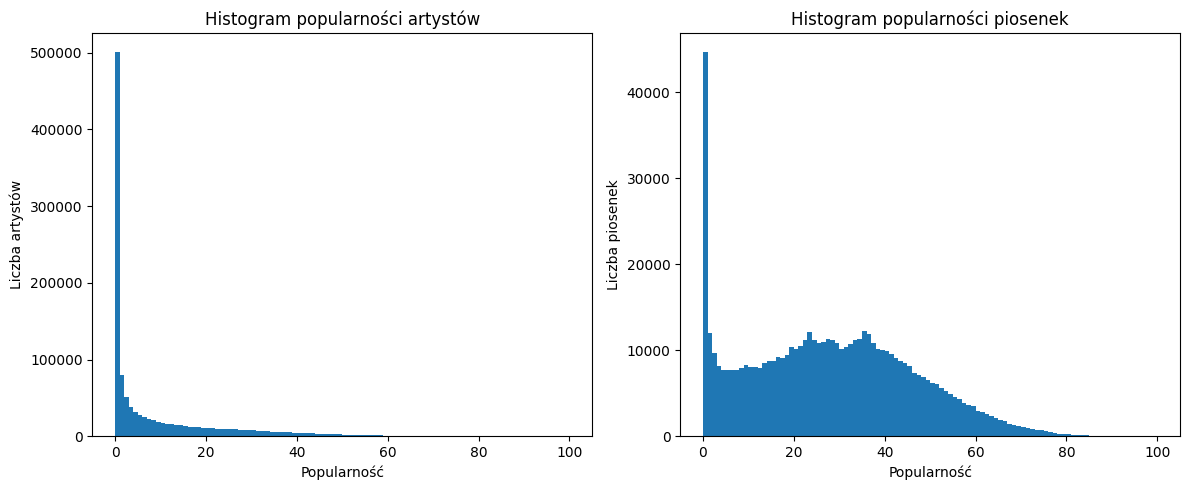

In [99]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_artists['popularity'], bins=100)
plt.title('Histogram popularności artystów')
plt.xlabel('Popularność')
plt.ylabel('Liczba artystów')

plt.subplot(1, 2, 2)
plt.hist(df_tracks['popularity'], bins=100)
plt.title('Histogram popularności piosenek')
plt.xlabel('Popularność')
plt.ylabel('Liczba piosenek')

plt.tight_layout()
plt.show()

In [100]:
df_artists = df_artists.loc[df_artists['popularity'] >= 55, :]
df_tracks = df_tracks.loc[df_tracks['popularity'] >= 55, :]
df_tracks = df_tracks.loc[df_tracks['duration_ms'] < 600_000, :]

df_artists = remove_weird_genres(df_artists)
df_tracks = filter_english_only(df_tracks)

In [101]:
df_tracks = extract_artist_id(df_tracks)

In [102]:
df_songs = pd.merge(df_tracks, df_artists, left_on='main_artist_id', right_on='id')
df_songs = df_songs.rename(columns=lambda col: col.replace('_x', '_track').replace('_y', '_artist'))
df_songs = df_songs.drop_duplicates(subset=['name_track', 'name_artist'])

In [106]:
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]

df_songs_info = df_songs[songs_info_cols].copy()
df_songs = df_songs.drop(columns=songs_info_cols)

In [107]:
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df_songs_features = df_songs[songs_features_cols].copy()
df_songs = df_songs.drop(columns=songs_features_cols)

In [110]:
print(f"df_songs: {df_songs.shape}")
print(f"df_songs_info: {df_songs_info.shape}")
print(f"df_songs_features: {df_songs_features.shape}")

df_songs: (17471, 14)
df_songs_info: (17471, 3)
df_songs_features: (17471, 9)


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [113]:
X = df_songs_features

In [122]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # PCA
        self.pca = PCA(n_components=2, random_state=0)
        self.X_pca = np.array(self.pca.fit_transform(X))

        # UMAP
        self.umap = UMAP(n_components=2, random_state=0, low_memory=False, n_jobs=-1)
        self.X_umap = np.array(self.umap.fit_transform(X))

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(self.X_pca))

        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        # axes[0] - PCA, axes[1] - UMAP
        axes[0].scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
        axes[0].set_title("PCA")
        axes[0].set_xlabel("PC1")
        axes[0].set_ylabel("PC2")

        axes[1].scatter(self.X_umap[:, 0], self.X_umap[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
        axes[1].set_title("UMAP")
        axes[1].set_xlabel("UMAP1")
        axes[1].set_ylabel("UMAP2")

        fig.suptitle("Clustering visualization")
        plt.tight_layout()
        plt.show()


/Users/jakubciszewski/studia/sem6/pum/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jakubciszewski/studia/sem6/pum/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


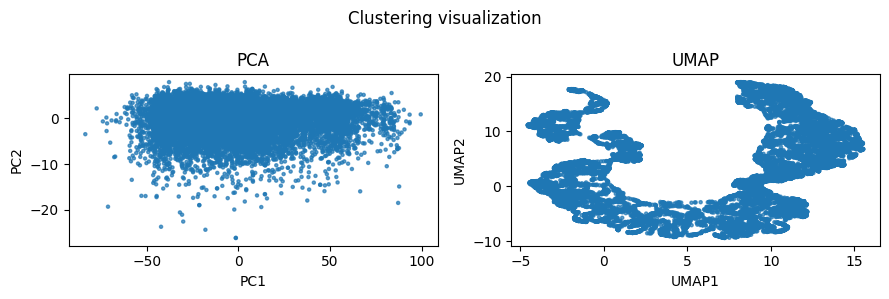

In [123]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

- W PCA nie widać clastrów
- Widać ją w przypadku UMAP
- Nieliniowa metoda UMAP dała wizualnie lepsze wyniki, bo mozemy zauwazyć strukturę clastrów

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [ ]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

In [ ]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


// skomentuj tutaj

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

// skomentuj tutaj

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

// skomentuj tutaj

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

In [ ]:
clustering = HDBSCAN()
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

// skomentuj tutaj

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?